In [1]:
import os
import random
import shutil
import datetime
from multiprocessing import cpu_count
import skimage.exposure
import Augmentor
import tensorflow as tf

import keras
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import RMSprop

os.environ['MKL_NUM_THREADS'] = str(cpu_count())
os.environ['GOTO_NUM_THREADS'] = str(cpu_count())
os.environ['OMP_NUM_THREADS'] = str(cpu_count())
os.environ['openmp'] = 'True'

config = tf.ConfigProto(device_count={"GPU" : 1, "CPU" : cpu_count()})
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

#=============================================================================================
# Precheck on directory structure
#=============================================================================================

if os.listdir('8-bit/test_data/cell/'):
    print 'Warning! Files detected in test data directory!'
    print 'Moving files back to training data directory...'

    for f in os.listdir('8-bit/test_data/cell/'):
        shutil.move('8-bit/test_data/cell/'+f,'8-bit/training_data/cell/'+f)

    for f in os.listdir('8-bit/test_data/nocell/'):
        shutil.move('8-bit/test_data/nocell/'+f,'8-bit/training_data/nocell/'+f)

#=============================================================================================
# Construction of Convolution Neural Network
#=============================================================================================

print "Constructing Convolution Neural Network..."

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(80, 80, 1)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))
#
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(512, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))
#
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(512, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(512, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

optimizer = RMSprop(lr=1e-4)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

print "Done!"

#=============================================================================================
# Preparing training and test data
#=============================================================================================

from keras.preprocessing.image import ImageDataGenerator

print "Splitting all training data into 70% training and 30% test data directories..."

cell_data = os.listdir('8-bit/training_data/cell/')
nocell_data = os.listdir('8-bit/training_data/nocell/')

test_cell_data = random.sample(cell_data, int(0.3*len(cell_data)))
test_nocell_data = random.sample(nocell_data, int(0.3*len(nocell_data)))

for f in test_cell_data:
    shutil.move('8-bit/training_data/cell/'+f,'8-bit/test_data/cell/'+f)

for f in test_nocell_data:
    shutil.move('8-bit/training_data/nocell/'+f,'8-bit/test_data/nocell/'+f)



/opt/anaconda/envs/deeplearn/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Warning! Files detected in test data directory!
Moving files back to training data directory...
Constructing Convolution Neural Network...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 82, 82, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 8)         80        
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 82, 82, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 8)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 42, 42, 8)         0         
___

In [2]:

#=============================================================================================
# Augmenting data
#=============================================================================================

training_datagen = Augmentor.Pipeline('8-bit/training_data')

training_datagen.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)
training_datagen.zoom(probability=0.1, min_factor=1.05, max_factor=1.2)
training_datagen.skew_top_bottom(probability=0.2, magnitude=1)
training_datagen.skew_left_right(probability=0.2, magnitude=1)
training_datagen.shear(probability=0.3, max_shear_left=10, max_shear_right=10)
training_datagen.rotate_without_crop(probability=0.3, max_left_rotation=30, max_right_rotation=30, expand=False)
training_datagen.rotate90(probability=0.2)
training_datagen.rotate180(probability=0.2)
training_datagen.random_distortion(probability=0.3, grid_width=5, grid_height=5, magnitude=2)
training_datagen.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
training_datagen.status()

training_data = training_datagen.keras_generator(batch_size=32, scaled=True)

# test data
test_datagen = Augmentor.Pipeline('8-bit/test_data')

test_data = test_datagen.keras_generator(batch_size=32, scaled=True)

print "Done!"

#=============================================================================================
# Fitting data to model
#=============================================================================================

print "Fitting data to model..."

# Find number of epoch and validation steps
steps_epoch = len([filename for filename in os.listdir('8-bit/training_data/cell') if filename.endswith(".tif")]) + len([filename for filename in os.listdir('8-bit/training_data/nocell') if filename.endswith(".tif")])//32
steps_valid = len([filename for filename in os.listdir('8-bit/test_data/cell') if filename.endswith(".tif")]) + len([filename for filename in os.listdir('8-bit/test_data/nocell') if filename.endswith(".tif")])//32

# Checkpoint to only save the best model, metric = val_acc
strdate = datetime.datetime.today().strftime('%Y_%m_%d')

if not os.path.exists('models/'+strdate):
    os.makedirs('models/'+strdate)

filepath = "models/"+strdate+"/cc_model_"+strdate+".h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='acc', patience=1,)
callbacks_list = [checkpoint, earlystop]

# steps_per_epoch is number of images in training set
history = model.fit_generator(training_data, steps_per_epoch = steps_epoch, epochs = 25, callbacks=callbacks_list, validation_data = test_data, validation_steps = steps_valid, shuffle = True)

print "Done!"

#=============================================================================================
# Splitting final model into
#=============================================================================================

model = load_model(filepath)
# Serialize model to JSON
model_json = model.to_json()
with open(filepath[:-3]+".json", "w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model.save_weights(filepath)

#=============================================================================================
# Writing model summary to file
#=============================================================================================

with open('models/'+strdate+'/'+strdate+'_model_summary.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

print "Done!"


Initialised with 14002 image(s) found.
Output directory set to 8-bit/training_data/output.Operations: 10
	0: RotateRange (max_right_rotation=5.0 max_left_rotation=-5.0 probability=0.7 )
	1: Zoom (min_factor=1.05 max_factor=1.2 probability=0.1 )
	2: Skew (magnitude=1 skew_type=TILT_TOP_BOTTOM probability=0.2 )
	3: Skew (magnitude=1 skew_type=TILT_LEFT_RIGHT probability=0.2 )
	4: Shear (max_shear_right=10 max_shear_left=10 probability=0.3 )
	5: RotateStandard (max_right_rotation=30.0 max_left_rotation=-30.0 expand=False probability=0.3 )
	6: Rotate 90 (rotation=90 probability=0.2 )
	7: Rotate 180 (rotation=180 probability=0.2 )
	8: Distort (randomise_magnitude=True magnitude=2 grid_height=5 probability=0.3 grid_width=5 )
	9: RandomBrightness (min_factor=0.8 max_factor=1.2 probability=0.5 )
Images: 14002
Classes: 2
	Class index: 0 Class label: cell 
	Class index: 1 Class label: nocell 
Dimensions: 1
	Width: 80 Height: 80
Formats: 1
	 TIFF

You can remove operations using the appropriate i

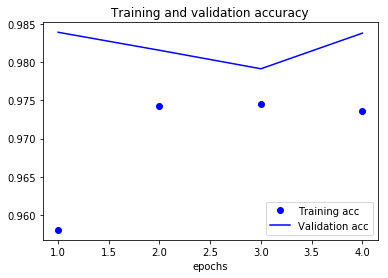

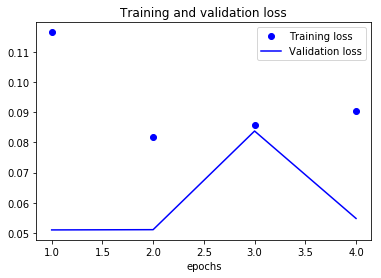

In [6]:
#=============================================================================================
# Plotting accuracy
#=============================================================================================

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.legend()
plt.savefig('Acc_starting.png')
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.legend()
plt.savefig('Loss_starting.png')
plt.show()

In [7]:
    #=============================================================================================
    # User definied parameters
    #=============================================================================================

    # CNN model paths
    model_weights_path = 'models/2019_03_06/cc_model_2019_03_06.h5'

    model.load_weights(model_weights_path)

In [8]:
# Finally evaluating model on the test data

# test data for accuracy plotting
test_datagen1 = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen1.flow_from_directory(
'8-bit/test_data',
target_size=(80, 80),
batch_size=32,
class_mode='categorical',
color_mode = 'grayscale',
shuffle=False)
test_loss, test_acc = model.evaluate_generator(test_generator, steps=200)
print('test acc:', test_acc)

Found 5999 images belonging to 3 classes.


ValueError: Error when checking target: expected dense_3 to have shape (2,) but got array with shape (3,)

In [ ]:
# Generating confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
#predictions = classifier.predict_generator(test_generator)
#matrix = metrics.confusion_matrix(test_generator, predictions)
#print(matrix)

test_generator2 = test_datagen1.flow_from_directory(
'8-bit/test_data',
target_size=(80, 80),
batch_size=32,
class_mode='binary',
color_mode = 'grayscale',
shuffle=False)

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator2)
Y_pred[Y_pred > 0.5] = 1
Y_pred[Y_pred < 0.5] = 0
print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, Y_pred))
print('Classification Report')
target_names = ['Cell','Nocell']
print(classification_report(test_generator2.classes, Y_pred, target_names=target_names))

In [ ]:
#=============================================================================================
# Recompiling training and test data together
#=============================================================================================

for f in os.listdir('8-bit/test_data/cell/'):
    shutil.move('8-bit/test_data/cell/'+f,'8-bit/training_data/cell/'+f)

for f in os.listdir('8-bit/test_data/nocell/'):
    shutil.move('8-bit/test_data/nocell/'+f,'8-bit/training_data/nocell/'+f)

In [ ]:
import shutil
import os

dirpath = os.path.join('8-bit/training_data/output/')
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)
    
print "Done!"